# Wykorzystanie procesorów graficznych (GPU) w algorytmach heurystycznych

Wykorzystamy paczkę CuPy

## Wyżarzanie równoległe

In [2]:
# Implementacja algorytmu wyżarzania równoległego używając własnego kernelu w CUDA
import os
import cupy as cp
from typing import Optional
from tqdm import tqdm

from funkcje_pomocnicze import calculate_energy_gpu



def parrarel_annealing_gpu(J, h, step_size: float, lambda_t_max: float, num_steps: int, num_trajectories: int,
                       schedule: Optional[list] = None, dtype = cp.float32):
    
    n = len(h)
    x = cp.zeros((n, num_trajectories), dtype=dtype)  # stan podstawowy dla H_innit = sum(x**2)
    momentum = cp.zeros((n, num_trajectories), dtype=dtype)
    state = cp.random.choice([dtype(-1.), dtype(1.)], size=(n, num_trajectories)) # losowy stan początkowy
    step_size = dtype(step_size)

    if schedule is None:
        schedule = [dtype(lambda_t_max * (1 - i/(num_steps -1))) for i in range(num_steps)]  # dlaczego nie linspace? chodzi o typy

    # cu_path = os.path.join("cuda_kernels", "pa_kernel.cu")
    # ptx_path = os.path.join("cuda_kernels", "pa_kernel.ptx")
    # command = f"nvcc --ptx --define-macro N={n} --define-macro M={num_trajectories} {cu_path} -o {ptx_path}"
    
    # os.system(command)
    kernel = cp.RawModule(path="cuda_kernels/pa_kernel.ptx")
    parrarel_annealing_step = kernel.get_function("parrarel_annealing_step")

    threadsperblock = 256  # Ilość wątków w bloku,
    blockspergrid_x = num_trajectories  # każdy blok zajmuje się trajektorią
    blockspergrid_y = (n + threadsperblock - 1) // threadsperblock  # wystarczająca ilość bloków by pomieścić całą kolumnę 
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    x_new = cp.empty_like(x)
    momentum_new = cp.empty_like(momentum)
    state_new = cp.empty_like(state)

    for k in tqdm(range(num_steps), desc="wyżarzanie równoległe GPU"):
   
        lambda_t = schedule[k]
        A = cp.matmul(J, state)
        parrarel_annealing_step(blockspergrid, (threadsperblock,), (A, h, x, momentum, 
                                                               lambda_t, step_size, n,
                                                               momentum_new, x_new, state_new))
        momentum = momentum_new
        x = x_new
        state = state_new

    return state, calculate_energy_gpu(J, h, state)


In [7]:
from funkcje_pomocnicze import read_instance, small_pegasus, test_pegasus
J, h = read_instance(test_pegasus.path, convention="minus_half")


J = cp.asarray(J, dtype=cp.float32)
h = cp.asarray(h, dtype=cp.float32)

states, energy = parrarel_annealing_gpu(J, h, step_size=0.01, lambda_t_max=10, num_steps=1000, num_trajectories=5000)
print(min(energy))

wyżarzanie równoległe GPU: 100%|██████████| 1000/1000 [00:00<00:00, 6984.60it/s]


-469.0


In [9]:
# E = -12772
# best found -12742 steps 10^4 trajectories 2^10 time approx 43s
# najperw trzeba raz przepuscić by kernel wszedł do pamięci podręcznej (można użyć mało kroków)
from funkcje_pomocnicze import read_instance, full_pegasus
J, h = read_instance(full_pegasus.path, convention="minus_half")


J = cp.asarray(J, dtype=cp.float32)
h = cp.asarray(h, dtype=cp.float32)


states, energy = parrarel_annealing_gpu(J, h, step_size=0.01, lambda_t_max=10, num_steps=10000, num_trajectories=2**10)
print(min(energy))

wyżarzanie równoległe GPU: 100%|██████████| 10000/10000 [00:43<00:00, 229.55it/s]


-12742.0


## Bruteforce

In [1]:
# brute force CUDA

import cupy as cp
from tqdm import tqdm

def select_lowest(energies, states, num_states):
    
    indices = cp.argpartition(energies, num_states)[:num_states]

    low_energies = energies[indices]
    low_states = states[indices]
    return low_energies, low_states

def sort_by_key(energies, states, num_states):
    order = cp.argsort(energies)[:num_states]

    low_energies = energies[order]
    low_states = states[order]
    return low_energies, low_states


def brute_force_gpu(Q,  num_states: int, sweep_size_exponent: int = 10, threadsperblock: int = 256):
    N, _ = Q.shape
    if N > 64:
        raise ValueError("Za wysoka wartość N. Ta implementacja wspiera co najwyżej 64 spiny (64-bitowy integer)")
    sweep_size = 2**sweep_size_exponent
    num_chunks = 2**(N-sweep_size_exponent)

   
    brute_force_kernel = cp.RawModule(path="cuda_kernels/brute_force_kernel.ptx")
    compute_energies = brute_force_kernel.get_function("compute_energies")

    blockspergrid = sweep_size//threadsperblock
    
    final_energies = cp.array([])
    final_states = cp.array([])
    
    for i in tqdm(range(num_chunks), desc="wyczerpujące przeszukiwanie"):

        energies = cp.empty(sweep_size, dtype=cp.float32)
        states = cp.empty(sweep_size, dtype=cp.int64)
        compute_energies((blockspergrid,), (threadsperblock,), 
                         (Q, cp.int32(N), cp.int32(sweep_size_exponent), energies, states, cp.int64(i)))

        low_energies, low_states = select_lowest(energies, states, num_states)
        
        final_energies = cp.concatenate((final_energies, low_energies))
        final_states = cp.concatenate((final_states, low_states))
        if i != 0:

            final_energies, final_states = select_lowest(final_energies, final_states, num_states)

    return sort_by_key(final_energies, final_states, num_states)

    

In [2]:
#test 
import numpy as np
from itertools import product
N = 16

Q = cp.random.uniform(-1, 1, size=(N, N), dtype=cp.float32)
Q = cp.triu(Q)

energies, states = brute_force_gpu(Q, 10)
print(energies)
print(states)

en = []
st = []
Q2 = cp.asnumpy(Q)
for state in tqdm(product([0, 1], repeat=N), total=2**N):
    s = np.array(state)
    e = s @ Q2 @ s.T
    en.append(e.item())
en.sort()
print(en[:10])

wyczerpujące przeszukiwanie: 100%|██████████| 64/64 [00:00<00:00, 511.80it/s]


[-10.97558308 -10.8951416  -10.67044544 -10.56989765 -10.54962635
 -10.47861958 -10.39052963 -10.36895084 -10.34971046 -10.25609016]
[22619. 20715. 55387. 63511. 55391. 22651. 22779. 22763. 20713. 63583.]


100%|██████████| 65536/65536 [00:00<00:00, 173271.83it/s]

[-10.975582778453827, -10.89514046907425, -10.670445024967194, -10.569896817207336, -10.549625813961029, -10.47861909866333, -10.390529096126556, -10.368949949741364, -10.349710404872894, -10.256089568138123]


In [7]:
# test bruteforce
import cupy as cp
import numpy as np
from itertools import product
from tqdm import tqdm
from funkcje_pomocnicze import read_instance, small_pegasus, ising_to_qubo

J, h = read_instance(small_pegasus.path, convention="dwave")
Q, offset = ising_to_qubo(J, h)
Q = cp.asarray(Q, dtype=cp.float32)

energies, states = brute_force_gpu(Q, 10, 20, 512)
print(energies + offset)
print(states)


wyczerpujące przeszukiwanie: 100%|██████████| 16/16 [00:00<00:00, 466.03it/s]

[-39. -37. -37. -37. -37. -37. -37. -37. -37. -37.]
[9375503. 7401720. 7403760. 7403764. 7403768. 7401712. 7401716. 7928048.
 7926008. 7928056.]


In [9]:
N = 33

Q = cp.random.uniform(-1, 1, size=(N, N), dtype=cp.float32)
Q = cp.triu(Q)

energies, states = brute_force_gpu(Q, 10, 20, 512)
print(min(energies))

wyczerpujące przeszukiwanie: 100%|██████████| 8192/8192 [00:11<00:00, 685.79it/s]

-51.468971252441406


# Symulowana bifurkacja 

In [ ]:
# Balistyczna symulowana bifurkacja ngpu naiwna
import cupy as cp
from math import sqrt
from typing import Optional
from tqdm import tqdm

from funkcje_pomocnicze import calculate_energy_gpu


def wall_gpu(x: cp.ndarray, y: cp.ndarray):
    mask = cp.abs(x) > 1
    x[mask] = cp.sign(x[mask])
    y[mask] = 0
    return x, y


def balistic_simulated_bifurcation_gpu_naive(J, h, num_steps, time_step, num_trajectories: int, 
                                   a_0: Optional[float] = None, c_0_scaling: Optional[float] = None):
    if a_0 is None:
        a_0 = 1

    N, _ = J.shape
    mean_J = cp.sqrt(cp.sum(cp.square(J)) / (N * (N - 1)) )
    c_0 = 0.5 / (mean_J * sqrt(N))

    if c_0_scaling is not None:
        c_0 *= c_0_scaling


    a = cp.linspace(0, a_0, num=num_steps)

    x = cp.zeros((N, num_trajectories))
    y = cp.random.uniform(-0.1, 0.1, (N, num_trajectories))

    for t in tqdm(range(num_steps), desc="symulowana bifurkacja"):
        y += (-1 * (a_0 - a[t]) * x + c_0 * (cp.matmul(J,x) + h.reshape((N, 1)))) * time_step  # x(t)
        x += a_0 * y * time_step # x(t + 1)

        x, y = wall_gpu(x, y)

    x = cp.sign(x)
    return x, calculate_energy_gpu(J, h, x)

In [18]:
# Implementacja SBM używając własnego kernelu
import cupy as cp
from math import sqrt
from typing import Optional
from tqdm import tqdm

from funkcje_pomocnicze import calculate_energy_gpu

def balistic_simulated_bifurcation_gpu(J, h, num_steps, time_step, num_trajectories: int, 
                                   a_0: Optional[float] = None, c_0_scaling: Optional[float] = None):
    if a_0 is None:
        a_0 = 1
    
    N, _ = J.shape
    mean_J = np.sqrt(np.sum(np.square(J)) / (N * (N - 1)) )
    c_0 = 0.5 / (mean_J * sqrt(N))

    if c_0_scaling is not None:
        c_0 *= c_0_scaling

    dtype = cp.float32

    a = [dtype(i * a_0 / (num_steps - 1)) for i in range(num_steps)]
    
    a_0 = dtype(a_0)
    c_0 = dtype(c_0.item())
    time_step = dtype(time_step)

    x = cp.zeros((N, num_trajectories), dtype=dtype)
    y = cp.random.uniform(-0.1, 0.1, (N, num_trajectories), dtype=dtype)

    x_new = cp.empty_like(x)
    y_new = cp.empty_like(y)

    threadsperblock = 256  # Ilość wątków w bloku,
    blockspergrid_x = num_trajectories  # każdy blok zajmuje się trajektorią
    blockspergrid_y = (N + threadsperblock - 1) // threadsperblock  # wystarczająca ilość bloków by pomieścić całą kolumnę 
    blockspergrid = (blockspergrid_x, blockspergrid_y)
    
    kernel = cp.RawModule(path="cuda_kernels/sbm_kernel.ptx")
    update_y = kernel.get_function("update_y")
    update_x_and_wall = kernel.get_function("update_x_and_wall")

    for t in tqdm(range(num_steps), desc="balistyczna symulowana bifurkacja"):
        A = cp.matmul(J, x) + h.reshape((N, 1))
        update_y(blockspergrid, (threadsperblock,),(x, y, A, 
                                                    a_0, a[t], c_0, time_step, N,
                                                    y_new))
        y = y_new
        update_x_and_wall(blockspergrid, (threadsperblock,),(x, y, 
                                                             a_0, time_step, N, 
                                                             x_new, y_new))
        x = x_new
        y = y_new

    x = cp.sign(x)
    return x, calculate_energy_gpu(J, h, x)

symulowana bifurkacja:   0%|          | 0/200 [00:00<?, ?it/s]

symulowana bifurkacja: 100%|██████████| 200/200 [00:00<00:00, 733.43it/s]


Otrzymana energia: -467.0
Stan podstawowy: -469.0


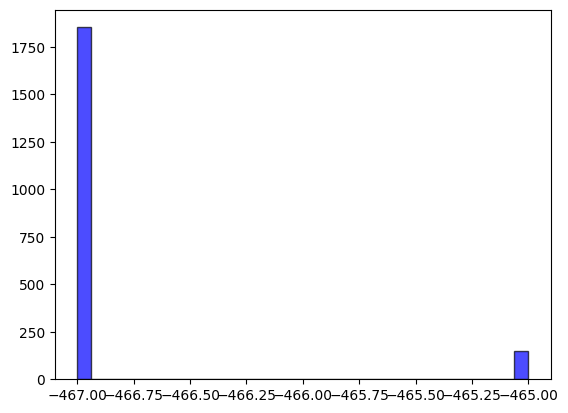

In [6]:
import matplotlib.pyplot as plt 
from funkcje_pomocnicze import read_instance, test_pegasus, small_pegasus
J, h = read_instance(test_pegasus.path, convention="minus_half")

J = cp.asarray(J, dtype=cp.float32)
h = cp.asarray(h, dtype=cp.float32)

states, energies = balistic_simulated_bifurcation_gpu_naive(J, h, time_step=0.5, num_steps=200, num_trajectories=2000, c_0_scaling=0.7)

print(f"Otrzymana energia: {min(energies)}")
print(f"Stan podstawowy: {test_pegasus.best_energy}")


plt.hist(cp.asnumpy(energies), bins=32, color='blue', edgecolor='black', alpha=0.7)
plt.show()

In [7]:
import cupy as cp
from math import sqrt
from typing import Optional
from tqdm import tqdm

from funkcje_pomocnicze import calculate_energy_gpu


def wall_gpu(x: cp.ndarray, y: cp.ndarray):
    mask = cp.abs(x) > 1
    x[mask] = cp.sign(x[mask])
    y[mask] = 0
    return x, y


def discrete_simulated_bifurcation_gpu_naive(J, h, num_steps, time_step, num_trajectories: int, 
                                   a_0: Optional[float] = None, c_0_scaling: Optional[float] = None):
    if a_0 is None:
        a_0 = 1

    N, _ = J.shape
    mean_J = cp.sqrt(cp.sum(cp.square(J)) / (N * (N - 1)) )
    c_0 = 0.5 / (mean_J * sqrt(N))

    if c_0_scaling is not None:
        c_0 *= c_0_scaling


    a = cp.linspace(0, a_0, num=num_steps)

    x = cp.zeros((N, num_trajectories))
    y = cp.random.uniform(-0.1, 0.1, (N, num_trajectories))

    for t in tqdm(range(num_steps), desc="symulowana bifurkacja"):
        y += (-1 * (a_0 - a[t]) * x + c_0 * (cp.matmul(J,cp.sign(x)) + h.reshape((N, 1)))) * time_step  # x(t)
        x += a_0 * y * time_step # x(t + 1)

        x, y = wall_gpu(x, y)

    x = cp.sign(x)
    return x, calculate_energy_gpu(J, h, x)

In [25]:
# Implementacja Discrete Simulated Bifurcation
import cupy as cp
from math import sqrt
from typing import Optional
from tqdm import tqdm

from funkcje_pomocnicze import calculate_energy_gpu


def discrete_simulated_bifurcation_gpu(J, h, num_steps, time_step, num_trajectories: int, 
                                   a_0: Optional[float] = None, c_0_scaling: Optional[float] = None):
    if a_0 is None:
        a_0 = 1
    
    N, _ = J.shape
    mean_J = cp.sqrt(cp.sum(cp.square(J)) / (N * (N - 1)) )
    c_0 = 0.5 / (mean_J * sqrt(N))

    if c_0_scaling is not None:
        c_0 *= c_0_scaling

    dtype = cp.float32

    a = [dtype(i * a_0 / (num_steps - 1)) for i in range(num_steps)]
    
    a_0 = dtype(a_0)
    c_0 = dtype(c_0.item())
    time_step = dtype(time_step)

    x = cp.zeros((N, num_trajectories), dtype=dtype)
    y = cp.random.uniform(-0.1, 0.1, (N, num_trajectories), dtype=dtype)

    x_new = cp.empty_like(x)
    y_new = cp.empty_like(y)

    threadsperblock = 256  # Ilość wątków w bloku,
    blockspergrid_x = num_trajectories  # każdy blok zajmuje się trajektorią
    blockspergrid_y = (N + threadsperblock - 1) // threadsperblock  # wystarczająca ilość bloków by pomieścić całą kolumnę 
    blockspergrid = (blockspergrid_x, blockspergrid_y)
    
    kernel = cp.RawModule(path="cuda_kernels/sbm_kernel.ptx")
    update_y = kernel.get_function("update_y")
    update_x_and_wall = kernel.get_function("update_x_and_wall")

    for t in tqdm(range(num_steps), desc="dyskretna symulowana bifurkacja"):
        sign_x = cp.sign(x)
        A = cp.matmul(J, sign_x) + h.reshape((N, 1))
        update_y(blockspergrid, (threadsperblock,),(x, y, A, 
                                                    a_0, a[t], c_0, time_step, N,
                                                    y_new))
        y = y_new
        update_x_and_wall(blockspergrid, (threadsperblock,),(x, y, 
                                                             a_0, time_step, N,
                                                             x_new, y_new))
        x = x_new
        y = y_new

    x = cp.sign(x)
    return x, calculate_energy_gpu(J, h, x)


dyskretna symulowana bifurkacja: 100%|██████████| 50000/50000 [00:08<00:00, 6234.24it/s]


Otrzymana energia: -2750.0


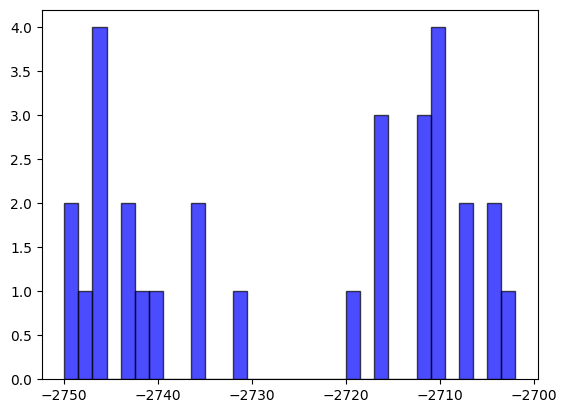

In [46]:
import cupy as cp
import os
import matplotlib.pyplot as plt
from funkcje_pomocnicze import read_instance, test_pegasus, small_pegasus, pegasus

#J, h = read_instance(test_pegasus.path, convention="minus_half")
P8 = pegasus(os.path.join("instancje", "Pegasus", "P8_CBFM-P.txt"), -2752.0)
J, h = read_instance(P8.path, convention="minus_half")

J = cp.asarray(J, dtype=cp.float32)
h = cp.asarray(h, dtype=cp.float32)


states, energies = discrete_simulated_bifurcation_gpu(J, h, time_step=1, num_steps=50000, num_trajectories=2*15, c_0_scaling=0.3)
print(f"Otrzymana energia: {min(energies)}")
#print(f"Stan podstawowy: {test_pegasus.best_energy}")


plt.hist(cp.asnumpy(energies), bins=32, color='blue', edgecolor='black', alpha=0.7)
plt.show()

# 